**Tarif Engine**

Classes

TarEng

Demogr

Economics

Tariff

**GTar**

Inputs:

g: gender 0 and 1

x: age

s: schlussalter

fB: Death Benefit Level

fM: Maturity Benefit

**ATar**

Inputs:

g: gender 0 and 1

x: age

s: schlussalter

iNrPayments: number of annuity payments

fR: Annuity Benefit Start

fDeltaR: Linear increase relative to fR

iNrIncreases: Nr of Benefit Increases




In [349]:
import numpy as np
import matplotlib.pyplot as plt

class MyIO:
    def __init__(self, strName):
        self.me = strName

    def getvariablenames(self):
        members = [attr for attr in dir(self) if not \
                 callable(getattr(self, attr)) and not attr.startswith("__")] 
        return(members)
    
    def clean(self):
        strName = self.me
        members = self.getvariablenames()
        for i in members: 
            strTask = "self."+i+"= None"
            exec(strTask)
        self.me = strName
    
    def print(self):
        instance_vars = vars(self)
        for v_name, v_value in instance_vars.items():
            print("%s --> %s"%(repr(v_name),repr(v_value)))

    def vstrPrint(self):
        instance_vars = vars(self)
        strOut = "Trace %s \n------------ \n"%(self.me)
        for v_name, v_value in instance_vars.items():
            strOut+= "%s --> %s \n"%(repr(v_name),repr(v_value))
        strOut +="------------ \n"
        return(strOut)
    
class TarEng():
    def __init__(self,i=0.025, t0= 2025, omega=120,nCF=100):
        self.symDirTariffs = dict()
        self.symDirDemogr = dict()
        self.symDirEco = dict()
        self.pInp = MyIO("Input")
        self.pOut = MyIO("Output")
        self.pTrace = MyIO("Trace")
        self.pGPar = MyIO("GlobalParameter")
        self.pGPar.iTech = i
        self.pGPar.vTech = 1./(1.+i)
        self.pGPar.t0 = t0
        self.pGPar.omega=omega
        self.pGPar.nCF=nCF
        self.AddModules()

    def AddModules(self):
        self.symDirTariffs = {"A":ATar,"A2":A2Tar,"G":GTar}
        self.symDirDemogr = {"CH":QxCH}
        self.symDirEco ={"iTech":ITech}
        

    def ParseTask(self, strInput,strSep=";",bDefaults=True):
        Tokens=strInput.split(strSep)
        self.pInp.strInp = strInput
        self.pInp.Tarif = None
        self.pInp.Econ = None
        self.pInp.Demo = None
        self.pInp.Param = dict()
        for i in Tokens:
            SubTok = i.split("=")
            if len(SubTok) == 1:
                if SubTok[0] in self.symDirTariffs.keys():
                    self.pInp.Tarif = SubTok[0]
                if SubTok[0] in self.symDirDemogr.keys():
                    self.pInp.Demo = SubTok[0]
                if SubTok[0] in self.symDirEco.keys():
                    self.pInp.Econ = SubTok[0]
            else:
                self.pInp.Param[SubTok[0]] = SubTok[1]
        
        if bDefaults:
            if self.pInp.Tarif == None:
                self.pInp.Tarif = "A"
            if self.pInp.Demo == None:
                self.pInp.Demo = "CH"
            if self.pInp.Econ == None:
                self.pInp.Econ = "iTech"

       # init objects
        self.psymE = self.symDirEco[self.pInp.Econ](self)
        self.psymD = self.symDirDemogr[self.pInp.Demo](self)
        self.psymT = self.symDirTariffs[self.pInp.Tarif](self)
 
      # do Stuff
        self.psymT.vDoCalc()

    def vPlot(self):
        x=int(self.pInp.Param["x"])
        periods = self.pGPar.nCF
        omega=self.pGPar.omega
        xmax = min(omega,x+periods)
        plt.figure(1)
        plt.plot(range(x,xmax),self.pOut.dDK[x:xmax])
        plt.grid(True)
        plt.figure(2)
        plt.plot(range(0,xmax-x),self.pOut.dCF[0:xmax-x])
        plt.grid(True)
        
        
    
    def TraceIO(self):
        strOut = ""
        for i in [self.pInp,self.pOut,self.pTrace,self.pGPar]:
            strOut += i.vstrPrint()
        print(strOut)
        

In [351]:
class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscounT(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1

In [398]:

class ATar():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.nOmega = self.psymParent.pGPar.omega
        self.psymB = self.StdBenefit 
        self.psymQx = self.psymParent.psymD.Qx
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega)
        self.psymParent.pOut.dBenefitLevel= np.zeros(self.psymParent.pGPar.omega)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(periods)
    
    def StdBenefit(self,x,param=[]):
#iNrPayments: number of annuity payments
#fR: Annuity Benefit Start
#fDeltaR: Linear increase
#iNrIncreases: Nr of Benefit Increases
        dValue=0
        if x>=self.s and x<self.s+self.iNrPayments: 
           dValue = 1 + self.fDeltaR *min(x-self.s,self.iNrIncreases)
        return(dValue*self.fR)

    def CalcPV(self):
        dDK = self.psymParent.pOut.dDK
        gender = self.gender
        x = self.x
        s = min(self.s+self.iNrPayments,self.nOmega)
        param = self.param
        PV = 0
        dDK[s] = PV
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            dBen = self.psymB(i,param=param)
            self.psymParent.pOut.dBenefitLevel[i]=dBen
            PV = dBen + px * self.dV * PV # a_x = 1 + p_x v a_{x+1}
            dDK[i] = PV
    
    def CalcCF(self):
        # Caculation of expected cash flows
        gender = self.gender
        x = self.x
        s = self.s
        param = self.param
        periods = self.psymParent.pGPar.nCF
        CF =  self.psymParent.pOut.dCF
        px = 1.
        for i in range(x,self.nOmega):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px  * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)

    def PopulateParam(self):
        
        self.gender = int(self.psymParent.pInp.Param["gender"])
        self.x = int(self.psymParent.pInp.Param["x"])
        self.s = int(self.psymParent.pInp.Param["s"])
        self.fR = float(self.psymParent.pInp.Param["fR"])
        self.iNrPayments = int(self.psymParent.pInp.Param["iNrPayments"])
        self.fDeltaR = float(self.psymParent.pInp.Param["fDeltaR"])
        self.iNrIncreases = int(self.psymParent.pInp.Param["iNrIncreases"])
 
        self.param=[]

    def vDoCalc(self):
        print ("Task :",self.psymParent.pInp.Param)
        self.PopulateParam()
        self.CalcPV()
        self.CalcCF()


class A2Tar():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.nOmega = self.psymParent.pGPar.omega
        self.psymQx = self.psymParent.psymD.Qx
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
        self.dIrate = self.psymParent.pGPar.iTech
        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega)
        self.psymParent.pTrace.dDK12= np.zeros(self.psymParent.pGPar.omega)
        self.psymParent.pTrace.dDK1= np.zeros(self.psymParent.pGPar.omega)
        self.psymParent.pTrace.dDK2= np.zeros(self.psymParent.pGPar.omega)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(periods)
        self.psymParent.pTrace.strExecTasks = []

        self.psymB1 = self.ConstantBenefit
        self.psymB2 = self.ConstantBenefit
        self.psymB12 = self.ConstantBenefit
        self.psymR1 = self.ConstantBenefit
        self.psymR2 = self.ConstantBenefit
        self.psymR12 = self.ConstantBenefit
        self.psymM1 = self.ConstantBenefit
        self.psymM2 = self.ConstantBenefit
        self.psymM12 = self.ConstantBenefit
        
        self.symM=Markov()
        self.symM.vDefineModel(4)
        self.QxLevelJoint = 1.
        self.QxLevelWidow = 1.
        
    def StdBenefit(self,x,param=[]):
#iNrPayments: number of annuity payments
#fR: Annuity Benefit Start
#fDeltaR: Linear increase
#iNrIncreases: Nr of Benefit Increases
        dValue=0
        if x>=self.s and x<self.s+self.iNrPayments: 
           dValue = 1 + self.fDeltaR *min(x-self.s,self.iNrIncreases)
        return(dValue*self.fR)

    def ConstantBenefit(self,x,param=[]):
        return(1)

    def ZeroBenefit(self,x,param=[]):
        return(0.)    

    def PopulateParam(self):
        self.x = int(self.psymParent.pInp.Param["x"])
        self.s = int(self.psymParent.pInp.Param["s"])

        self.gender1 = int(self.psymParent.pInp.Param["gender1"])
        self.gender2 = int(self.psymParent.pInp.Param["gender2"])
        self.deltaxy = int(self.psymParent.pInp.Param["deltaxy"])
        
        self.param=[]
        Tokens=["fM12","fM1","fM2","fR1","fR2","fR12","fB1","fB2","fB12"]
        for i in Tokens:
            if i in self.psymParent.pInp.Param.keys():
                dValue =  float(self.psymParent.pInp.Param[i])
            else:
                dValue = 0
            strExec="self."+i+"="+str(dValue)
            self.psymParent.pTrace.strExecTasks.append(strExec)
            exec(strExec)
    
    def vDoCalc(self):
        print ("Task :",self.psymParent.pInp.Param)
        self.PopulateParam()
        self.CalcPV()
        self.CalcCF()

    def CalcPV(self):
        dDK= self.psymParent.pOut.dDK
        dDK12= self.psymParent.pTrace.dDK12
        dDK1=self.psymParent.pTrace.dDK1
        dDK2=self.psymParent.pTrace.dDK2
        x = self.x
        s = self.s
        param = self.param
        n  = s-x
        gender1 = self.gender1
        gender2 = self.gender2 
        deltaxy = self.deltaxy
        self.symM.vSetDiscounT(self.dIrate)
        tt=s-1
        self.symM.vSetPost(tt,0,0,self.fM12*self.psymM12(s,param=param))
        self.symM.vSetPost(tt,1,1,self.fM1*self.psymM1(s,param=param))
        self.symM.vSetPost(tt,2,2,self.fM2*self.psymM2(s,param=param))
        for i in range(x,s):
            t = self.nT0 + i - x
            iy = i + deltaxy
            qx = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelJoint))
            qy = max(0,min(1,self.psymQx(gender2,iy,t)* self.QxLevelJoint))
            px = 1. - qx
            py = 1. - qy
            qxW = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelWidow))
            qyW = max(0,min(1,self.psymQx(gender2,iy,t) * self.QxLevelWidow))
            pxW = 1. - qxW
            pyW = 1. - qyW
            tt = i
            self.symM.vSetPij(tt,0,0,px*py)
            self.symM.vSetPij(tt,0,1,px*qy)
            self.symM.vSetPij(tt,0,2,qx*py)
            self.symM.vSetPij(tt,0,3,qx*qy)
            self.symM.vSetPij(tt,1,1,pxW)
            self.symM.vSetPij(tt,1,3,qxW)
            self.symM.vSetPij(tt,2,2,pyW)
            self.symM.vSetPij(tt,2,3,qyW)
            self.symM.vSetPre(tt,0,0,self.fR12*self.psymR12(i,param=param))
            self.symM.vSetPre(tt,1,1,self.fR1*self.psymR1(i,param=param))
            self.symM.vSetPre(tt,2,2,self.fR2*self.psymR2(i,param=param))
            self.symM.vSetPost(tt,0,1,self.fB12*self.psymB12(i,param=param))
            self.symM.vSetPost(tt,0,2,self.fB12*self.psymB12(i,param=param))
            self.symM.vSetPost(tt,0,3,self.fB12*self.psymB12(i,param=param))
            self.symM.vSetPost(tt,1,3,self.fB1*self.psymB1(i,param=param))
            self.symM.vSetPost(tt,2,3,self.fB2*self.psymB2(i,param=param))
        

        
        for i in range(x,s):
            dDK1[i] = self.symM.dGetDK(self.nOmega,0,i,1)
            dDK2[i] = self.symM.dGetDK(self.nOmega,0,i,2)
            dDK12[i] = self.symM.dGetDK(self.nOmega,0,i,0)
            dDK[i]=dDK12[i]


    def CalcCF(self):
        CF =  self.psymParent.pOut.dCF
        x = self.x
        s = self.s
        for i in range(x,s):
            CF[i-x]= self.symM.dGetCF(self.nOmega,x,i,0)


class GTar():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.nOmega = self.psymParent.pGPar.omega
        self.psymB = self.ConstantBenefit 
        self.psymM = self.ConstantBenefit # We incialise actually A_x
        self.psymQx = self.psymParent.psymD.Qx
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(periods)
    
    def ConstantBenefit(self,x,param=[]):
        return(1.)

    def ZeroBenefit(self,x,param=[]):
        return(0.)    

    def PopulateParam(self):
        self.gender = int(self.psymParent.pInp.Param["gender"])
        self.x = int(self.psymParent.pInp.Param["x"])
        self.s = int(self.psymParent.pInp.Param["s"])
        self.fB = int(self.psymParent.pInp.Param["fB"])
        self.fM = int(self.psymParent.pInp.Param["fM"])
        self.param=[]

    def CalcPV(self):
        dDK = self.psymParent.pOut.dDK
        gender = self.gender
        x = self.x
        s = self.s
        param = self.param
        # Calculation of present value by means of recursion
        PV = self.psymM(s,param=param) * self.fM
        dDK[s] = PV
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param)*self.fB + px * self.dV * PV
            dDK[i] = PV
    
    def CalcCF(self):
        # Caculation of expected cash flows
        gender = self.gender
        x = self.x
        s = self.s
        param = self.param
        periods = self.psymParent.pGPar.nCF
        CF =  self.psymParent.pOut.dCF
        px = 1.
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)
    
    def vDoCalc(self):
        print ("Task :",self.psymParent.pInp.Param)
        self.PopulateParam()
        self.CalcPV()
        self.CalcCF()

class QxCH():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.psymParent.pOut.strHelloQx = "Hello QX"
        self.dQx=self.QxNoReduction
    
    def Qx(self,gender,x,t,param =[]):
        # This is our default mortality
        if gender == 0:
            a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
        else:
            a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
        if x>110: a[3]= 0
        return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

    def QxNoReduction(self,gender,x,t,param =[]):
        # This is our default mortality
        t = self.psymParent.pGPar.t0
        if gender == 0:
            a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
        else:
            a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
        return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

    def QxMedieval(self,gender,x,t,param =[]):
        a=-9.13275
        b= 8.09432e-2
        c= -1.1018e-5
        value=math.exp(a+(b+c*x)*x)
        alpha = 7.26502413
        beta = 0.01342065
        return(max(0,min(1,alpha*value+beta)))

class ITech():
    def __init__(self,psymParent):
        self.psymParent=psymParent

    def dV(self,nPeriod):
        return(self.psymParent.pGPar.vTech)




Task : {'gender': '0', 'x': '20', 's': '110', 'fB': '0', 'fM': '1000000'}
Trace Input 
------------ 
'me' --> 'Input' 
'strInp' --> 'G;iTech;gender=0;x=20;s=110;fB=0;fM=1000000' 
'Tarif' --> 'G' 
'Econ' --> 'iTech' 
'Demo' --> 'CH' 
'Param' --> {'gender': '0', 'x': '20', 's': '110', 'fB': '0', 'fM': '1000000'} 
------------ 
Trace Output 
------------ 
'me' --> 'Output' 
'strHelloQx' --> 'Hello QX' 
'dDK' --> array([      0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,    9293.51703465,
          9527.32330144,    9767.12623343,   10013.09167145,
         10265.3913076 ,   10524.20301781,   10789.71122354,
         11062.1072856 ,   11341.58993

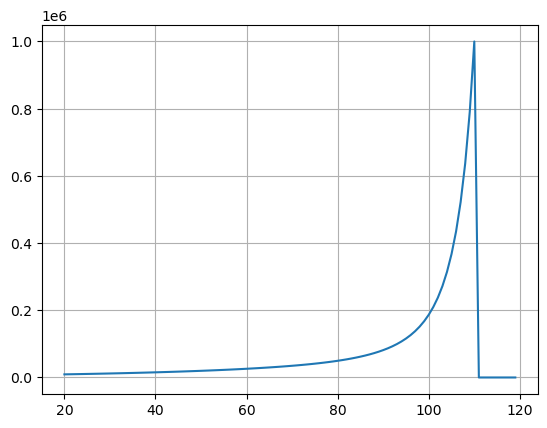

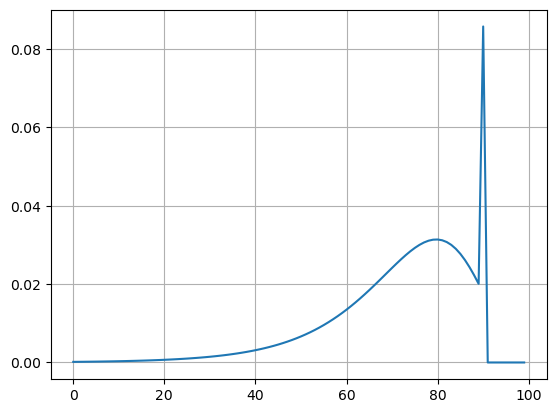

In [400]:
a = TarEng()
a.ParseTask("G;iTech;gender=0;x=20;s=110;fB=0;fM=1000000")
a.vPlot()
a.TraceIO()

Task : {'gender': '0', 'x': '65', 's': '65', 'iNrPayments': '20', 'fR': '12000', 'fDeltaR': '0.05', 'iNrIncreases': '10'}
Trace Input 
------------ 
'me' --> 'Input' 
'strInp' --> 'A;iTech;gender=0;x=65;s=65;iNrPayments=20;fR=12000;fDeltaR=0.05;iNrIncreases=10' 
'Tarif' --> 'A' 
'Econ' --> 'iTech' 
'Demo' --> 'CH' 
'Param' --> {'gender': '0', 'x': '65', 's': '65', 'iNrPayments': '20', 'fR': '12000', 'fDeltaR': '0.05', 'iNrIncreases': '10'} 
------------ 
Trace Output 
------------ 
'me' --> 'Output' 
'strHelloQx' --> 'Hello QX' 
'dDK' --> array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
     

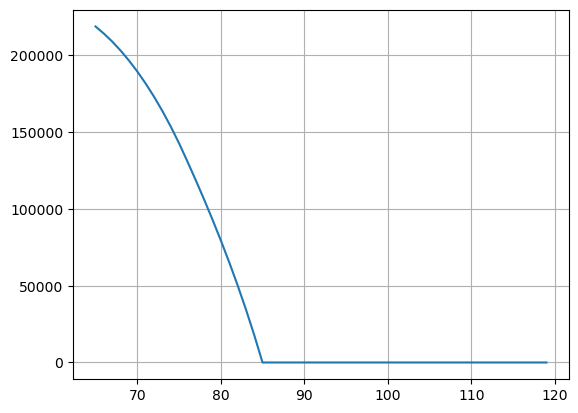

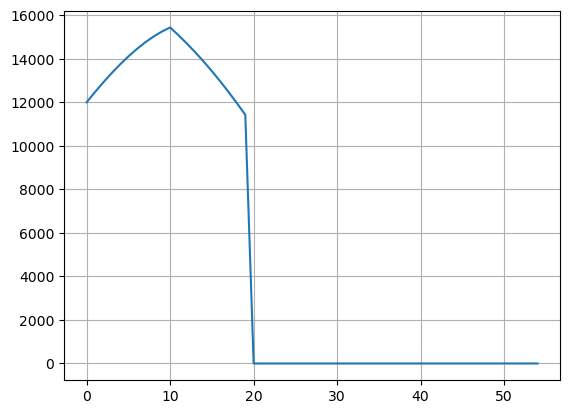

In [402]:
strTask = "A;iTech;gender=0;x=65;s=65;iNrPayments=20;fR=12000;fDeltaR=0.05;iNrIncreases=10"
a.ParseTask(strTask)
a.vPlot()
a.TraceIO()

Task : {'gender1': '0', 'gender2': '1', 'deltaxy': '3', 'x': '20', 's': '120', 'fR2': '12000'}
Trace Input 
------------ 
'me' --> 'Input' 
'strInp' --> 'A2;iTech;gender1=0;gender2=1;deltaxy=3;x=20;s=120;fR2=12000' 
'Tarif' --> 'A2' 
'Econ' --> 'iTech' 
'Demo' --> 'CH' 
'Param' --> {'gender1': '0', 'gender2': '1', 'deltaxy': '3', 'x': '20', 's': '120', 'fR2': '12000'} 
------------ 
Trace Output 
------------ 
'me' --> 'Output' 
'strHelloQx' --> 'Hello QX' 
'dDK' --> array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
       20175.54934335, 20620.91398339, 21073.36224146, 21532.79758808,
       21999.10344137, 22472.14165036, 22951.75089845, 23437.74502561,
       23929.91126815, 24428.00

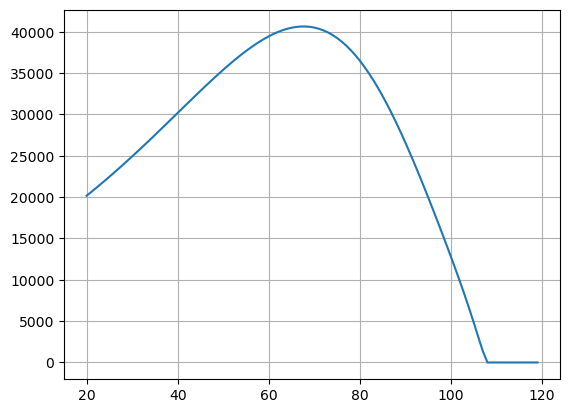

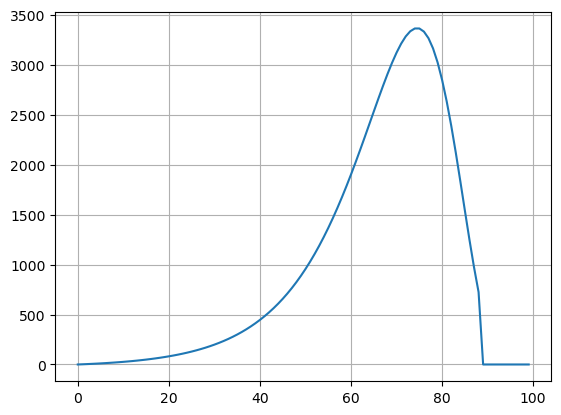

In [404]:
strTask = "A2;iTech;gender1=0;gender2=1;deltaxy=3;x=20;s=120;fR2=12000"
a.ParseTask(strTask)
a.vPlot()
a.TraceIO()